In [1]:
## which python is using
## when using Nipype_tutorial, it should be "/opt/miniconda-latest/envs/neuro/bin/python"
import sys
sys.executable

'/opt/miniconda-latest/envs/neuro/bin/python'

# Hands-on 1: how to create a fMRI preprocessing workflow

*written by Michael Notter & Luke Chang *

Purpose: set-up a complete fMRI analysis workflow.

## Preparation

This notebook use data from `datalad`. But you should also be able to adopt it to your own data

In [2]:
## %%bash
## datalad get -J 4 /data/ds000114/sub-0[234789]/ses-test/anat/sub-0[234789]_se...

## Preprocessing Workflow Structure

`1. Gunzip (Nipype)`

`2. Drop Dummy Scans (FSL)`

`3. Slice time Corrrection (SPM)`

`4. Motion Correction (SPM)`

`5. Artifact Detection`

`6. Segmentation (SPM)`

`7. Coregistration (FSL)`

`8. Smoothing (FSL)`

`9. Apply Binary Mask (FSL)`

`10. Remove linear Trends (Nipype)`

### Using SPM with MATLAB Common Runtime (MCR)

#### first, check the existing folders in the current nipype image.
Check `Test_spm.ipynb`.

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [3]:
%matplotlib inline

from nilearn import plotting

# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use

from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('opt/spm12-r7219/spm12_mcr/spm12')

from os.path import join

data_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/'
output_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc'

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Create Nodes and Workflow connections

Let's create all the nodes that we needs! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipline.



### Workflow
We recommend to create the workflow and establish all its connections at a later place in your script. this helps to have everything nicely together. But for this hands-on example, it makes sense to establish the connections between the nodes as we go.


And for this, we first need to creat a workflow:

In [4]:
preproc = Workflow(name='work_preproc', 
                   base_dir=join(output_dir, 'output/'))

### Gunzip

created `Gunzip` node as a template for the other nodes. Also, we've specified an `in_file` here so that we can directly test the nodes without worrying about the Input/Output data stream to the workflow. this will be taken care of in a later section.

In [5]:
from nipype.algorithms.misc import Gunzip

In [6]:
func_file = join(data_dir, 'sub-001/ses-d1/func/sub-001_ses-d1_task-exp_bold.nii.gz')

gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### Drop Dummy Scans

The functional image of this dataset were recorded with 5 dummy scans at the beginning (see). But those dummy scans were not yet taken out from the functional images.

To better illustrate this, let's plot the time course of a random voxel of the just defined `func_file`:

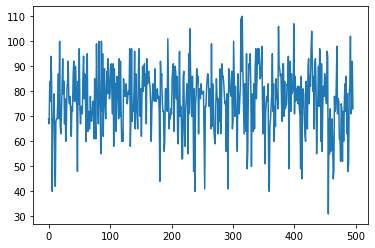

In [7]:
%matplotlib inline

import nibabel as nb
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :]);

Though the signal doesn't seem bad, but follow the previous approach.
Using `ExtractROI` to exclude dummy scans from the original data

In [8]:
from nipype.interfaces.fsl import ExtractROI

In [9]:
extract = Node(ExtractROI(t_min=5, t_size=-1, output_type='NIFTI'),
              name="extract")

This `ExtractROI` node can be connected to the `gunzip_func` node from above. To do this, we use the following commnad:

In [10]:
preproc.connect([(gunzip_func, extract, [('out_file', 'in_file')])])

### Motion correction

To correct for motion in the scanner, we will useing FSL's `MCFLIRT`.

In [11]:
from nipype.interfaces.fsl import MCFLIRT

In [12]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                      save_plots=True),
              name="mcflirt")

Connect the `MCFLIRT` node to the rest of the workflow.

In [13]:
preproc.connect([(extract, mcflirt, [('roi_file', 'in_file')])])

### Artifact Detection

We will use the realy cool and useful `ArtifactDetection` tool from Nipype to detect motion and intensity outliers in the functional images. The interface is initiated as follows:

In [14]:
from nipype.algorithms.rapidart import ArtifactDetect

In [15]:
art = Node(ArtifactDetect(norm_threshold=2,
                         zintensity_threshold=3,
                         mask_type='spm_global',
                         parameter_source='FSL',
                         use_differences=[True, False],
                         plot_type='svg'),
          name="art")

The parameters above mean the following:
* `norm_threshold` - Threshold to detect motion-related outlies when composite motion is being used
* `zintensity_threshold` - Intensity Z-threshold use to detection images that deviate from the mean
* `mask_type` - type of mask that should be used to mask the functional data. *spm_global* uses an spm_global like calculation to determine the brain mask
* `paramter_source` - Source of movement paramenters
* `use_differences` - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers.
    
And this is how you connect this node to the rest of the workflow:

In [16]:
preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                ])

### Segmentation of anatomical image
Now let's work on the anatomical image. In particular, let's use SPM's `NewSegment` to create probability maps for the gray matter, white matter tissue and CSF.

In [17]:
from nipype.interfaces.spm import NewSegment

In [18]:
# Use the following tissue specification to get a GM and WM probability map

tpm_img='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False, False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False, False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False, False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

In [19]:
segment = Node(NewSegment(tissues=tissues), name='segment')

We will again be using a `Gunzip` node to unzip the anatomical image that we then want to use as input to the segmentation node. We again also need to specify the anatomical image that we want to use in this case. As before, this will later also be handled directly by the Input/Output stream.

In [20]:
# Specify example input file
anat_file = join(data_dir, 'sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz')

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')


Now we can connect `NewSegment` node to the rest of the workflow.

In [21]:
preproc.connect([(gunzip_anat, segment, [('out_file', 'channel_files')])])

### Compute Coregistration Matrix

As a next step, we will make sure that the functional images are coregistered to the anatomical image. For this, we will use FSL's `FLIRT` function. As we just created a white matter probability map, we can use this together iwth the Boundary-Based Registration (BBR) cost function to optimize the image coregistration. As some helpful notes ...

* use a degree of freedom of 6
* specify the cost function as `bbr`
* use the `schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'`

In [22]:
from nipype.interfaces.fsl import FLIRT

In [23]:
coreg = Node(FLIRT(dof=6,
                  cost='bbr',
                  schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                  output_type='NIFTI'),
            name="coreg")

In [24]:
preproc.connect([(gunzip_anat, coreg, [('out_file', 'reference')]),
                (mcflirt, coreg, [('mean_img', 'in_file')])
                ])

As mentioned above, the `bbr` routine can use the subject-specific white matter probability map to guide the coregistration. But for this, we need to create a binary mask out of the WM probability map. This can easily be done by FSL' `Threshold` interface.

In [25]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                             args='-bin',
                             output_type='NIFTI'),
                   name="threshold_WM")

Now, to select the WM probability map that the `NewSegment` node created, we need some helper function. Because the output field `partial_volume_files` form the segmentation node, will give us a list of files, i.e., `[[GM_prob], [WM_prob], [], [], [], [], []]`. Therefore, using the following function, we can select only the last element of this list.

In [26]:
# Select WM segmentation file from segmentation output

def get_wm(files):
    return files[1][0]

# connecting the segmentation node with the threshold node
preproc.connect([(segment, threshold_WM, [(('native_class_images', get_wm),
                                         'in_file')])])

Now we can just connnect this `Threshold` node to the coregistration node from above.

In [27]:
preproc.connect([(threshold_WM, coreg, [('out_file', 'wm_seg')])])

### Appy Coregistration Matrix to functional image

Now that we konw the coregistration matrix to correctly overlay the functional mean image on the subject-specific anatomy, we nned to apply to coregistration to the whoel time series. This can be achieved with FSL's `FLIRT` as follows:

In [28]:
# specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                      apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="applywarp")

**Important**: As you can see above, we also specified a variable `desired_voxel_iso`. This is very important at this stage, otherwise `FLIRT` will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g., to 1-10GB per file). If you don't want to change the voxel resolution, use the additional parameter `no_resample=True`. Important, for this to work, you still need to define `apply_isoxfm`.

In [29]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(mcflirt, applywarp, [('out_file', 'in_file')]),
                (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                (gunzip_anat, applywarp, [('out_file', 'reference')])
                ])

### Smoothing

Next step is image smoothing. The most simple way to do this is to use FSL's or SPM's `Smooth` function. But for learning purposes, let's use FSL's `SUSAN` workflow as it is implemented in Nipype. Note that this time, we are importing a workflow instead of an interface.

In [30]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth

If you type `create_susan_smooth?` you can see how to specify the input variable to the susan workflow. In particular, they are ...

* `fwhm`: set this value 4 (or whichever value you want)
* `mask_file`: will be created in a later step
* `in_file`: will be handled while connection to other nodes in the preproc workflow

In [31]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4

In [32]:
preproc.connect([(applywarp, susan, [('out_file', 'inputnode.in_files')])])

### Create Binary Mask
There are many possible approaches on how you can mask your functional images.

One of them is not at all, one is with a simple brain mask and one that only considers certain kind of brain tissue, e.g., gray matter.

For the current example, we want to create a dilated gray matter mask. For this purpose, we need to:
1. Resample the gray matter probability map to the same resolution as the functional images
2. Threshold this resampled probability map at a specific value
3. Dilate this mask by some voxels to make the mask less conservative and more inclusive

The first step can be done in many ways (e.g., using freesurfer's `mri_convert`, `nibabel`) but in our case, we will use FSL's `FLIRT`. The trick is to use the probability mask, as input and a reference file.

In [33]:
from nipype.interfaces.fsl import FLIRT

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                     output_type='NIFTI'),
               name="resample")

The second and the third step can luckily be done with just one node. We can take almost the same `Threshold` node as above. We just need to add another additional argument: `-dilF` - which applies a maximum filtering of all voxels.

In [34]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                        args='-bin -dilF',
                        output_type='NIFTI'),
              name="mask_GM")

# select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

Now we can connect the resample and the gray matter mask node to the segmentation node and each other.

In [35]:
preproc.connect([(segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                     ]),
                (resample, mask_GM, [('out_file', 'in_file')])
                ])

### Apply the binary mask

Now we can connect this dilated gray matter mask to the susan node, as well as actually applying this to the resulting smoothed images.

In [36]:
preproc.connect([(mask_GM, susan, [('out_file', 'inputnode.mask_file')])])

To apply the mask to the smoothed functional images, we will use FSL's `ApplyMask` interface.

In [37]:
from nipype.interfaces.fsl import ApplyMask

**Important**: The susan workflow gives out a list of files, i.e., `[smoothed_func.nii]` instead of just the filename directly. If we would use a normal `Node` for `ApplyMask` this would lead to the following error:

`TraitError: .....`

To prevent this we will be using a `MapNode` and specify the `in_file` as it's iterfield.

Like this, the node is capable to handle a list of inputs as it will know that it has to apply itself iteratively to the list intputs.

In [38]:
from nipype import MapNode

In [39]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name='mask_func',
                    iterfield=["in_file"])

In [40]:
preproc.connect([(susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')])
                ])

### Remove linear trends in functional images
Last but not least. 
Let's use Nipype's `TSNR` module to remove linear and quadratic trends in the functionally smoothed images. For this, you only have to specify the `regress_poly` parameter in the node initiation.

In [41]:
from nipype.algorithms.confounds import TSNR

In [42]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

In [43]:
preproc.connect([(mask_func, detrend, [('out_file', 'in_file')])])

### Data input with `SelectFiles` and `iterables`

This is all nice and well, but so far we still had to specify the input values for `gunzip_anat` and `gunzip_func` ourselves. How can we scale this up to multiple subjects and/or multiple functional images and make the workflow take the input directly from the BIDS dataset?

For this, we need `SelectFiles` and `iterables`! It's rather simple, specify a template and fill-up the placeholder variables.

In [44]:
# import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/ses-d1/anat/'
                     'sub-{subject_id}_ses-d1_T1w.nii.gz',
             'func': 'sub-{subject_id}/ses-{ses_id}/func/'
                     'sub-{subject_id}_ses-{ses_id}_task-{task_id}_bold.nii.gz'}

# Create SelectFiles node
sf = Node(SelectFiles(templates,
                     base_directory=data_dir,
                     sort_filelist=True),
         name='selectfiles')
#sf.inputs.ses_id = 'd1'
# sf.inputs.ses_id = ['d1','d2','d3']
sf.inputs.task_id = 'exp'

Now we can specify over which subjects the workflow shoudl iterate. To test the workflow, let's still just look at subject 1.

In [45]:
subject_list = ['001', '002']
ses_list = ['d1','d2','d3']
sf.iterables = [('subject_id', subject_list),
                ('ses_id', ses_list)]

In [46]:
preproc.connect([(sf, gunzip_anat, [('anat', 'in_file')]),
                 (sf, gunzip_func, [('func', 'in_file')])])

## Visualize the workflow
Now that we're done, let's look at the workflow that we just created

200218-16:47:05,616 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/graph.png (graph2use=colored, simple_form=True).


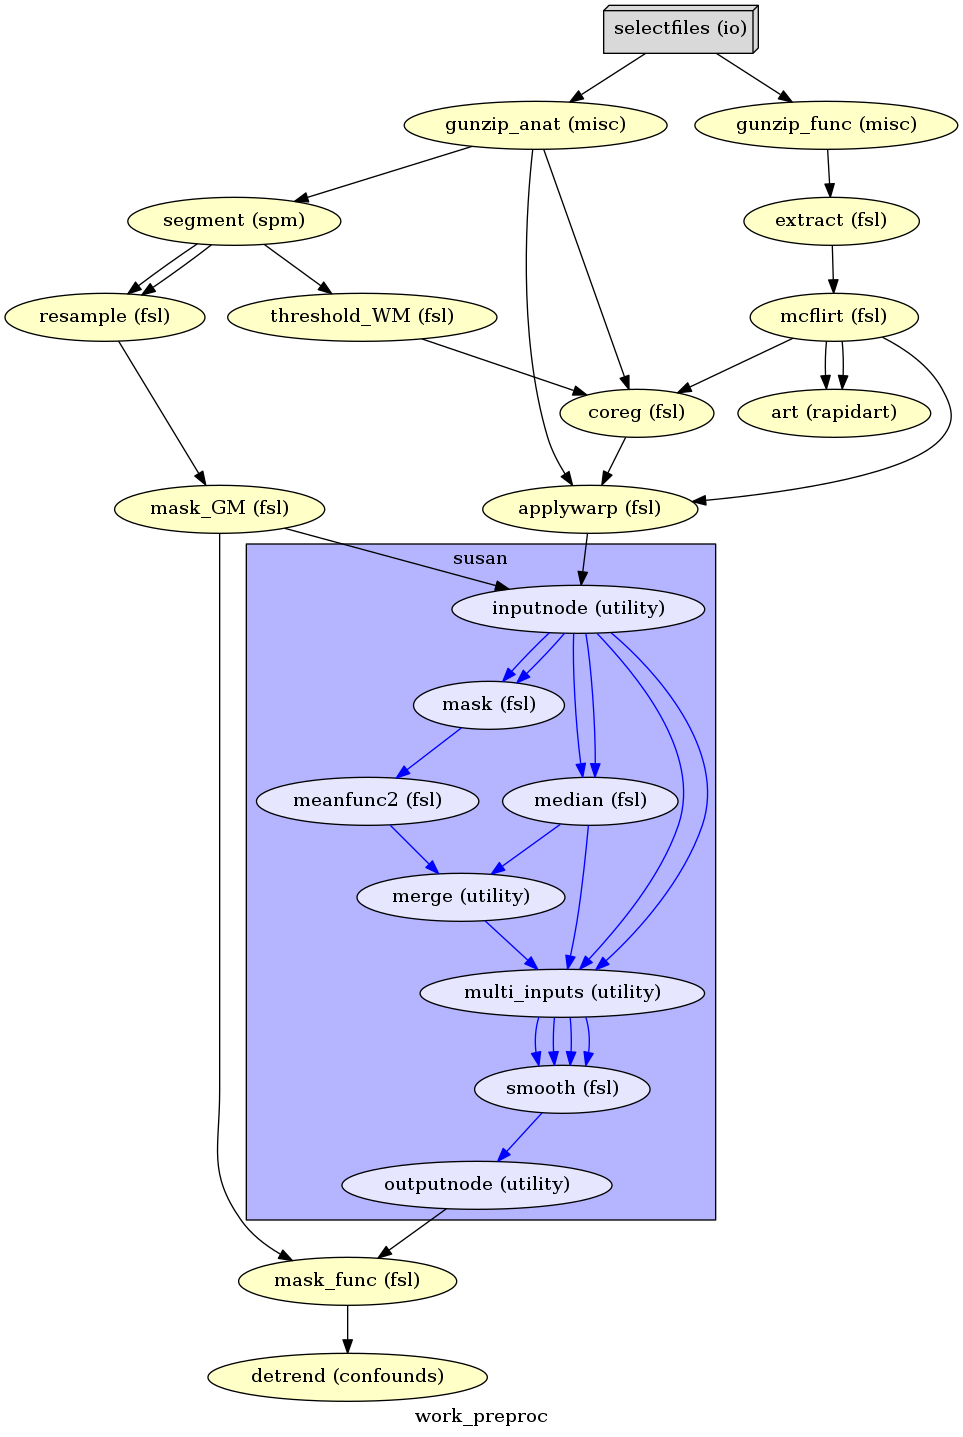

In [47]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# visualize the graph
from IPython.display import Image
Image(filename=join(output_dir, 'output/work_preproc/graph.png'), width=750)

## Run the Workflow

Now we are ready to run the workflow!

Be careful about the `n_procs` parameter if you run a workflow in `MultiProc` mode. `n_procs` specifies the nubmer of jobs/cores your commupter will use to run the workflow. 

If this number is too high your computer will try to execute too many things at once and will most likely crash.

**NOTE**: If you're using a Docker container and FLIRT fails to run without any good reason. You might need to change memory settings in the Docker preferences (6 GB should be enough for this workfow)


In [48]:
preproc.run('MultiProc', plugin_args={'n_procs': 6})

200218-16:47:54,399 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200218-16:47:54,499 nipype.workflow INFO:
	 Running in parallel.
200218-16:47:54,504 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 6/6.
200218-16:47:54,636 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_002/selectfiles".
200218-16:47:54,639 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/selectfiles".200218-16:47:54,640 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_001/selectfiles".

200218-16:47:

200218-16:48:10,577 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/extract".
200218-16:48:10,587 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/gunzip_func/sub-002_ses-d1_task-exp_bold.nii /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/extract/sub-002_ses-d1_task-exp_bold_roi.nii 5 -1
200218-16:48:12,523 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 6 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * work_preproc.extract
                       * work_preproc.segment
                       * work_preproc.s

200218-16:52:50,855 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.resample" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/resample".
200218-16:52:50,860 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.threshold_WM" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/threshold_WM".
200218-16:52:50,862 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/segment/c1sub-002_ses-d1_T1w.nii -ref /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/segment/c1sub-002_ses-d1_T1w.nii -out c1sub-002_ses-d1_T1w_flirt.nii -omat c1sub-002_ses-d1_T1w_flirt.mat -applyisoxfm 4.000000
200218-16:52:50,86

	 [Node] Setting-up "work_preproc.mcflirt" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/mcflirt".
200218-16:53:30,902 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/extract/sub-001_ses-d2_task-exp_bold_roi.nii -meanvol -out /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/mcflirt/sub-001_ses-d2_task-exp_bold_roi_mcf.nii.gz -plots
200218-16:53:32,836 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 3 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * work_preproc.mcflirt
                       * work_preproc.segment
                       * work_preproc.mcflirt
     

200218-16:57:17,105 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.resample" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_001/resample".
200218-16:57:17,114 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_001/segment/c1sub-001_ses-d1_T1w.nii -ref /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_001/segment/c1sub-001_ses-d1_T1w.nii -out c1sub-001_ses-d1_T1w_flirt.nii -omat c1sub-001_ses-d1_T1w_flirt.mat -applyisoxfm 4.000000
200218-16:57:19,46 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 4 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * work_preproc.resample
        

	 [Node] Running "multi_inputs" ("nipype.interfaces.utility.wrappers.Function")
200218-16:59:55,266 nipype.workflow INFO:
	 [Node] Finished "work_preproc.susan.multi_inputs".
200218-16:59:57,188 nipype.workflow INFO:
	 [Job 56] Completed (work_preproc.susan.multi_inputs).
200218-16:59:57,191 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 3 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * work_preproc.segment
                       * work_preproc.coreg
                       * work_preproc.coreg
                       * work_preproc.mcflirt
                       * work_preproc.mcflirt
200218-16:59:57,251 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.susan.smooth" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/susan/_ses_id_d1_subject_id_002/smooth".
200218-16:59:57,260 nipype.workflow INFO:
	 [Node] Setting-up "_smooth0" in "/media/hcp4715/Data/

200218-17:01:11,196 nipype.workflow INFO:
	 [Node] Finished "work_preproc.coreg".
200218-17:01:11,261 nipype.workflow INFO:
	 [Job 10] Completed (work_preproc.coreg).
200218-17:01:11,263 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 2 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * work_preproc.mcflirt
                       * work_preproc.susan.smooth
                       * work_preproc.segment
                       * work_preproc.coreg
                       * work_preproc.mcflirt
200218-17:01:11,320 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.applywarp" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_002/applywarp".
200218-17:01:11,344 nipype.workflow INFO:
	 [Node] Running "applywarp" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /media/hcp4715/Data/Data/RepDopa/BIDS/l

200218-17:01:49,359 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.detrend" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/detrend".
200218-17:01:49,367 nipype.workflow INFO:
	 [Node] Running "detrend" ("nipype.algorithms.confounds.TSNR")
200218-17:01:51,300 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 1 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * work_preproc.detrend
                       * work_preproc.coreg
                       * work_preproc.applywarp
                       * work_preproc.mcflirt
                       * work_preproc.segment
                       * work_preproc.coreg
200218-17:01:58,726 nipype.workflow INFO:
	 [Node] Finished "work_preproc.detrend".
200218-17:01:59,307 nipype.workflow INFO:
	 [Job 59] Completed (work_preproc.detrend).
200218-17:01:59,310 nipype.workflow INFO:
	 [MultiProc]

	 [Node] Finished "work_preproc.susan.meanfunc2".
200218-17:03:31,395 nipype.workflow INFO:
	 [Job 13] Completed (work_preproc.susan.meanfunc2).
200218-17:03:31,398 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 1 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * work_preproc.coreg
                       * work_preproc.applywarp
                       * work_preproc.segment
                       * work_preproc.coreg
                       * work_preproc.mcflirt
200218-17:03:31,459 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.susan.median" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/susan/_ses_id_d3_subject_id_002/median".
200218-17:03:31,473 nipype.workflow INFO:
	 [Node] Setting-up "_median0" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/susan/_ses_id_d3_subject_id_002/median/mapflow/_median0".
200

200218-17:04:59,539 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.art" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_001/art".
200218-17:04:59,549 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
200218-17:05:01,482 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 0 jobs ready. Free memory (GB): 26.95/28.15, Free processors: 0/6.
                     Currently running:
                       * work_preproc.art
                       * work_preproc.susan.smooth
                       * work_preproc.susan.smooth
                       * work_preproc.coreg
                       * work_preproc.segment
                       * work_preproc.coreg
200218-17:05:04,935 nipype.workflow INFO:
	 [Node] Finished "work_preproc.art".
200218-17:05:05,485 nipype.workflow INFO:
	 [Job 104] Completed (work_preproc.art).
200218-17:05:05,488 nipype.workflow INFO:
	 [MultiProc] Runni

200218-17:05:59,918 nipype.workflow INFO:
	 [Node] Finished "work_preproc.detrend".
200218-17:06:01,539 nipype.workflow INFO:
	 [Job 39] Completed (work_preproc.detrend).
200218-17:06:01,541 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 0 jobs ready. Free memory (GB): 27.15/28.15, Free processors: 1/6.
                     Currently running:
                       * work_preproc.coreg
                       * work_preproc.resample
                       * work_preproc.susan.smooth
                       * work_preproc.coreg
                       * work_preproc.coreg
200218-17:06:03,639 nipype.workflow INFO:
	 [Node] Finished "work_preproc.resample".
200218-17:06:05,543 nipype.workflow INFO:
	 [Job 107] Completed (work_preproc.resample).
200218-17:06:05,546 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 1 jobs ready. Free memory (GB): 27.35/28.15, Free processors: 2/6.
                     Currently running:
                       * work_preproc.coreg
             

200218-17:07:25,624 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 27.75/28.15, Free processors: 4/6.
                     Currently running:
                       * work_preproc.applywarp
                       * work_preproc.coreg
200218-17:07:25,670 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.applywarp" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/applywarp".
200218-17:07:25,677 nipype.workflow INFO:
	 [Node] Running "applywarp" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/mcflirt/sub-001_ses-d2_task-exp_bold_roi_mcf.nii.gz -ref /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_001/gunzip_anat/sub-001_ses-d1_T1w.nii -out sub-001_ses-d2_task-exp_bold

200218-17:08:37,697 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 27.55/28.15, Free processors: 3/6.
                     Currently running:
                       * work_preproc.susan.mask
                       * work_preproc.susan.mask
                       * work_preproc.coreg
200218-17:08:38,502 nipype.workflow INFO:
	 [Node] Finished "_mask0".
200218-17:08:38,507 nipype.workflow INFO:
	 [Node] Finished "work_preproc.susan.mask".
200218-17:08:39,696 nipype.workflow INFO:
	 [Job 72] Completed (work_preproc.susan.mask).
200218-17:08:39,698 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 27.75/28.15, Free processors: 4/6.
                     Currently running:
                       * work_preproc.susan.mask
                       * work_preproc.coreg
200218-17:08:39,744 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.susan.meanfunc2" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nip

fslstats /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_001/applywarp/sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.nii -k /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_001/mask_GM/c1sub-001_ses-d1_T1w_flirt_thresh.nii -p 50 
200218-17:10:36,245 nipype.workflow INFO:
	 [Node] Finished "_mask_func0".
200218-17:10:36,251 nipype.workflow INFO:
	 [Node] Finished "work_preproc.mask_func".
200218-17:10:37,814 nipype.workflow INFO:
	 [Job 98] Completed (work_preproc.mask_func).
200218-17:10:37,817 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 27.55/28.15, Free processors: 3/6.
                     Currently running:
                       * work_preproc.susan.median
                       * work_preproc.susan.mask
                       * work_preproc.susan.smooth
200218-17:10:37,863 nipype.workflow INFO:
	 [Node] Setting-up "work_pre

In [49]:
!tree -L 3 {join(output_dir, 'output/work_preproc/')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/
├── graph.png
├── _ses_id_d1_subject_id_001
│   ├── applywarp
│   │   ├── sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.mat
│   │   └── sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.nii
│   ├── art
│   │   ├── mask.sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz
│   │   └── plot.sub-001_ses-d1_task-exp_bold_roi_mcf.svg
│   ├── coreg
│   │   ├── sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz_mean_reg_flirt.mat
│   │   └── sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz_mean_reg_flirt.nii
│   ├── detrend
│   │   ├── detrend.nii.gz
│   │   ├── mean.nii.gz
│   │   ├── stdev.nii.gz
│   │   └── tsnr.nii.gz
│   ├── extract
│   │   └── sub-001_ses-d1_task-exp_bold_roi.nii
│   ├── gunzip_anat
│   │   └── sub-001_ses-d1_T1w.nii
│   ├── gunzip_func
│   │   └── sub-001_ses-d1_task-exp_bold.nii
│   ├── mask_func
│   │   └── mapflow
│   ├── mask_GM
│   │   └── c1sub-001_ses-d1_T1w_flirt_thresh.nii
│   ├── mcflirt
│   │   ├── sub-00

Text(0, 0.5, 'translation (mm)')

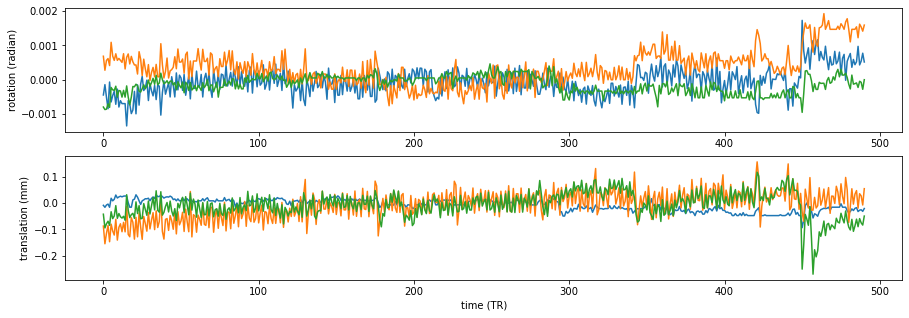

In [50]:
%matplotlib inline

# plot the motion parameter
import numpy as np
import matplotlib.pyplot as plt

par = np.loadtxt(join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/mcflirt/'
                      'sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz.par'))

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radian)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

Motion parameters seems to look ok. 

What about the detection of artifact?

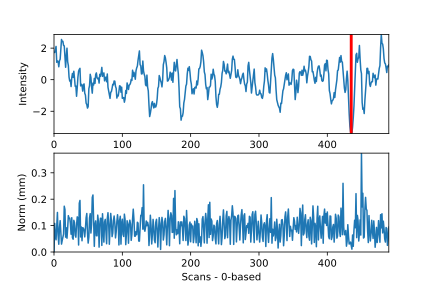

In [51]:
# showing the artifact detection output

from IPython.display import SVG
SVG(filename=join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/art/'
                      'plot.sub-001_ses-d1_task-exp_bold_roi_mcf.svg'))

Which volumes are problematic?

In [52]:
outliers = np.loadtxt(join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/art/'
                      'art.sub-001_ses-d1_task-exp_bold_roi_mcf_outliers.txt'))
list(outliers.astype('int'))

[434, 435, 436]

### Masks and Probability maps

let's see what all the masks and probability maps look like.

For this, we will use `nilearn`'s `plot_anat` function.

In [53]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_stat_map

output = join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/')

First, let's look at the tissue probability maps.

In [54]:
anat = join(output, 'gunzip_anat/sub-001_ses-d1_T1w.nii')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


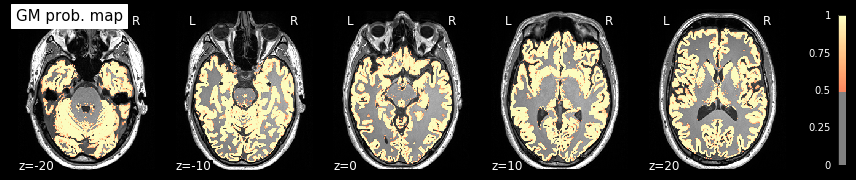

In [55]:
plot_stat_map(
    join(output, 'segment/c1sub-001_ses-d1_T1w.nii'), title = 'GM prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-20, 30, 10), dim=-1);

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


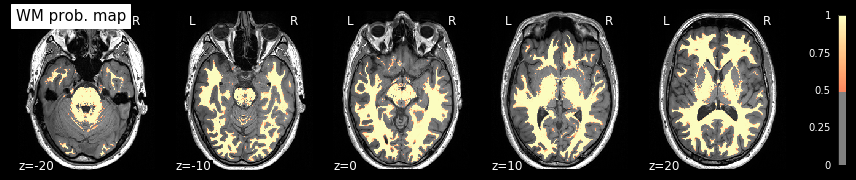

In [56]:
plot_stat_map(
    join(output, 'segment/c2sub-001_ses-d1_T1w.nii'), title = 'WM prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-20, 30, 10), dim=-1);

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


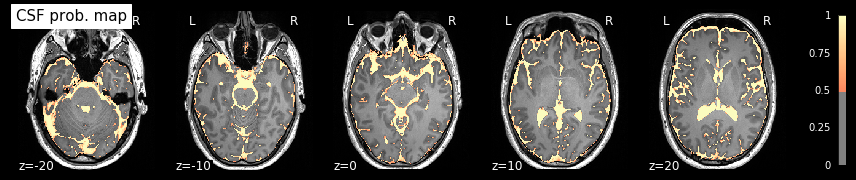

In [57]:
plot_stat_map(
    join(output, 'segment/c3sub-001_ses-d1_T1w.nii'), title = 'CSF prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-20, 30, 10), dim=-1);

And how the gray matter mask look like that we used on the functional images?

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


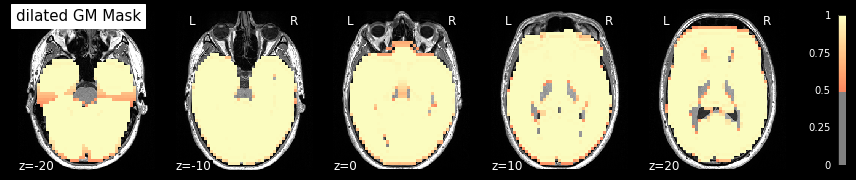

In [58]:
plot_stat_map(
    join(output, 'mask_GM/c1sub-001_ses-d1_T1w_flirt_thresh.nii'), title="dilated GM Mask", cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-20, 30, 10), dim=-1);

### Functioanl image transformations

Let's also investigate the transformation that we applied to the functional images.

In [59]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_epi

output = join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/')

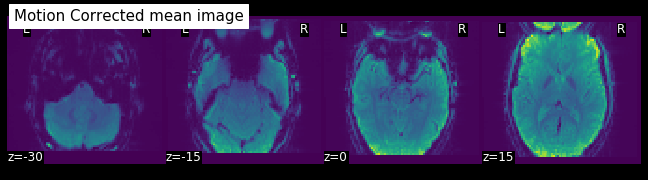

In [60]:
plot_epi(join(output, 'mcflirt/sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz_mean_reg.nii.gz'),
        title='Motion Corrected mean image', display_mode='z', 
        cut_coords=range(-30, 30, 15),
        cmap=plt.cm.viridis)

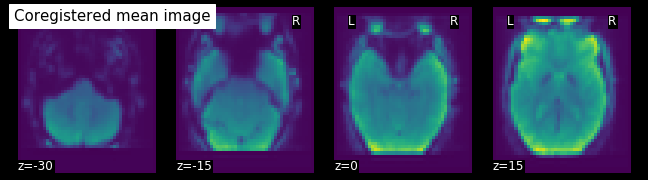

In [61]:
mean = nli.mean_img(join(output, 'applywarp/sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.nii'))

plot_epi(mean, title='Coregistered mean image', display_mode='z', 
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

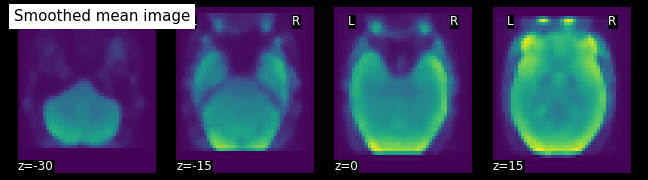

In [62]:
mean = nli.mean_img(join(output_dir, 'output/work_preproc/susan/_ses_id_d1_subject_id_001/smooth/mapflow/_smooth0/',
                        'sub-001_ses-d1_task-exp_bold_roi_mcf_flirt_smooth.nii.gz'))

plot_epi(mean, title='Smoothed mean image', display_mode='z', 
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

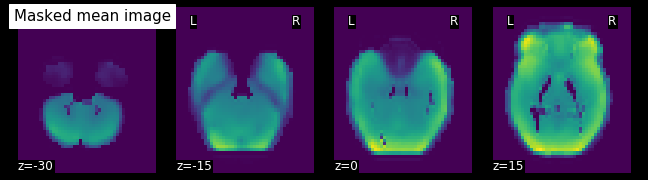

In [63]:
mean = nli.mean_img(join(output, 'mask_func/mapflow/_mask_func0/',
                        'sub-001_ses-d1_task-exp_bold_roi_mcf_flirt_smooth_masked.nii'))

plot_epi(mean, title='Masked mean image', display_mode='z', 
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

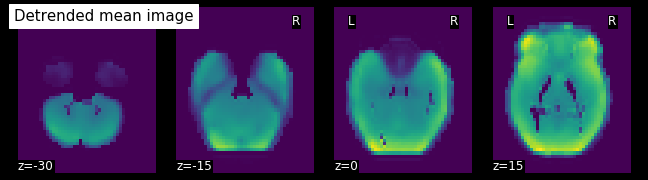

In [64]:
plot_epi(join(output, 'detrend/mean.nii.gz'),
         title='Detrended mean image',
         display_mode='z',
         cut_coords=range(-30, 30, 15),
         cmap=plt.cm.viridis)

That's all nice and beautiful, but what did smoothing and detrending actually do to the data?

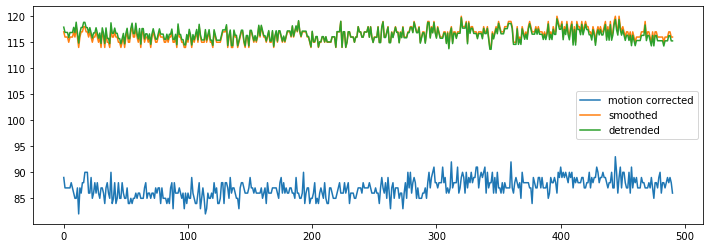

In [68]:
%matplotlib inline

import nibabel as nb

output = join(output_dir, 'output/work_preproc/_ses_id_d1_subject_id_001/')

# load the relevant datasets

mc = nb.load(join(output, 'applywarp/sub-001_ses-d1_task-exp_bold_roi_mcf_flirt.nii'))
smooth = nb.load(join(output_dir, 'output/work_preproc/susan/_ses_id_d1_subject_id_001/smooth/mapflow/_smooth0/',
                        'sub-001_ses-d1_task-exp_bold_roi_mcf_flirt_smooth.nii.gz'))

detrended_data = nb.load(join(output, 'detrend/detrend.nii.gz'))

# plot a representative voxel
x, y, z = 32, 34, 43

fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_data()[x, y, z, :])
plt.plot(smooth.get_data()[x, y, z, :])
plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(['motion corrected', 'smoothed', 'detrended'])

## Data output with `DataSink`

The results look fine, but we don't need all those temporary files. So let's use Datasink to keep only those files that we actually need for the 1st and 2nd level analysis.

In [70]:
from nipype.interfaces.io import DataSink

output_folder = 'datasink_handson'

datasink = Node(DataSink(base_directory=join(output_dir, 'output/'),
                        container=output_folder),
               name = 'datasink')

Now the next step is to specify all the output that we want to keep in our output folder `output`. Make sure to keep:

* from the artifact detection node the outlier file as well as the outlier plot
* from the motion correction node the motion parameters
* from the last node, the detrended functional image

In [71]:
preproc.connect([(art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (detrend, datasink, [('detrended_file', 'preproc.@func')]),
                ])

### Run the workflow

After adding the datasink folder, let's run the preprocessing again.

In [72]:
preproc.run('MultiProc', plugin_args={'n_procs': 7})

200218-18:11:50,422 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200218-18:11:50,539 nipype.workflow INFO:
	 Running in parallel.
200218-18:11:50,544 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200218-18:11:50,683 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_002/selectfiles".
200218-18:11:50,686 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_002/selectfiles".
200218-18:11:50,689 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/selectfiles".
200218-18:11:

200218-18:12:02,628 nipype.workflow INFO:
	 [Job 12] Cached (work_preproc.susan.mask).
200218-18:12:02,641 nipype.workflow INFO:
	 [Job 14] Cached (work_preproc.susan.median).
200218-18:12:02,654 nipype.workflow INFO:
	 [Job 33] Cached (work_preproc.susan.mask).
200218-18:12:02,663 nipype.workflow INFO:
	 [Job 35] Cached (work_preproc.susan.median).
200218-18:12:03,602 nipype.workflow INFO:
	 [Node] Finished "work_preproc.art".
200218-18:12:04,558 nipype.workflow INFO:
	 [Job 46] Completed (work_preproc.art).
200218-18:12:04,561 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 27.75/28.15, Free processors: 5/7.
                     Currently running:
                       * work_preproc.art
                       * work_preproc.art
200218-18:12:04,622 nipype.workflow INFO:
	 [Job 13] Cached (work_preproc.susan.meanfunc2).
200218-18:12:04,628 nipype.workflow INFO:
	 [Job 34] Cached (work_preproc.susan.meanfunc2).
200218-18:12:04,632 nipype.workf


200218-18:12:20,711 nipype.workflow INFO:
	 [Node] Outdated cache found for "work_preproc.detrend".
200218-18:12:20,728 nipype.workflow INFO:
	 [Node] Running "detrend" ("nipype.algorithms.confounds.TSNR")
200218-18:12:20,937 nipype.workflow INFO:
	 [Node] Finished "work_preproc.art".
200218-18:12:22,575 nipype.workflow INFO:
	 [Job 88] Completed (work_preproc.art).
200218-18:12:22,579 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 27.55/28.15, Free processors: 4/7.
                     Currently running:
                       * work_preproc.detrend
                       * work_preproc.detrend
                       * work_preproc.detrend
200218-18:12:22,721 nipype.workflow INFO:
	 [Job 79] Cached (work_preproc.susan.multi_inputs).
200218-18:12:22,732 nipype.workflow INFO:
	 [Job 95] Cached (work_preproc.applywarp).
200218-18:12:22,738 nipype.workflow INFO:
	 [Job 106] Cached (work_preproc.gunzip_func).
200218-18:12:22,744 nipype.workflow IN

200218-18:12:36,666 nipype.workflow INFO:
	 [Node] Running "detrend" ("nipype.algorithms.confounds.TSNR")
200218-18:12:38,591 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 27.75/28.15, Free processors: 5/7.
                     Currently running:
                       * work_preproc.detrend
                       * work_preproc.detrend
200218-18:12:38,663 nipype.workflow INFO:
	 [Job 120] Cached (work_preproc.susan.merge).
200218-18:12:40,652 nipype.workflow INFO:
	 [Job 121] Cached (work_preproc.susan.multi_inputs).
200218-18:12:42,622 nipype.workflow INFO:
	 [Node] Finished "work_preproc.detrend".
200218-18:12:42,654 nipype.workflow INFO:
	 [Job 122] Cached (work_preproc.susan.smooth).
200218-18:12:44,594 nipype.workflow INFO:
	 [Job 82] Completed (work_preproc.detrend).
200218-18:12:44,596 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 2 jobs ready. Free memory (GB): 27.95/28.15, Free processors: 6/7.
                     Current

In [73]:
!tree -L 3 {join(output_dir, 'output/datasink_handson')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/datasink_handson
└── preproc
    ├── _ses_id_d1_subject_id_001
    │   ├── detrend.nii.gz
    │   ├── plot.sub-001_ses-d1_task-exp_bold_roi_mcf.svg
    │   └── sub-001_ses-d1_task-exp_bold_roi_mcf.nii.gz.par
    ├── _ses_id_d1_subject_id_002
    │   ├── detrend.nii.gz
    │   ├── plot.sub-002_ses-d1_task-exp_bold_roi_mcf.svg
    │   └── sub-002_ses-d1_task-exp_bold_roi_mcf.nii.gz.par
    ├── _ses_id_d2_subject_id_001
    │   ├── detrend.nii.gz
    │   ├── plot.sub-001_ses-d2_task-exp_bold_roi_mcf.svg
    │   └── sub-001_ses-d2_task-exp_bold_roi_mcf.nii.gz.par
    ├── _ses_id_d2_subject_id_002
    │   ├── detrend.nii.gz
    │   ├── plot.sub-002_ses-d2_task-exp_bold_roi_mcf.svg
    │   └── sub-002_ses-d2_task-exp_bold_roi_mcf.nii.gz.par
    ├── _ses_id_d3_subject_id_001
    │   ├── detrend.nii.gz
    │   ├── plot.sub-001_ses-d3_task-exp_bold_roi_mcf.svg
    │   └── sub-001_ses-d3_task-exp_bold_roi_mcf.nii.gz.par
    

Much better! But we still not there yet. There are many unnecessary file sepcifiers that we can get rid off. 

To do so, we can use `Datasink`'s `substitutions` parameter. 

For this, we create a list of tuples: on the left, we specify string that we want to replace and on the right, with what want to replact it with.

In [83]:
## use the following substitutions for the Datasink output

substitutions = [('_bold_roi_mcf', ''),
                ('.nii.gz.par', '.par'),
               ]

# To get ride of the folder '_subject_id_001' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s, 
                '_subject_id_%s/_sub-%s_detrend' %(s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' %s, '') for s in subject_list]
substitutions += [('_ses_id_%s/' %s, 'ses_%s' %s) for s in subject_list]

datasink.inputs.substitutions = substitutions

Before we run the preprocessing workflow again, let's first delete the current output folder:

In [84]:
!rm -rf {join(output_dir, 'output/datasink_handson')}

In [85]:
preproc.run('MultiProc', plugin_args={'n_procs': 7})

200219-17:11:46,549 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200219-17:11:46,668 nipype.workflow INFO:
	 Running in parallel.
200219-17:11:46,673 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:11:46,818 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d3_subject_id_002/selectfiles".
200219-17:11:46,820 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d2_subject_id_002/selectfiles".
200219-17:11:46,824 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/work_preproc/_ses_id_d1_subject_id_002/selectfiles".
200219-17:11:

200219-17:12:00,810 nipype.workflow INFO:
	 [Job 106] Cached (work_preproc.gunzip_func).
200219-17:12:02,691 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12:02,754 nipype.workflow INFO:
	 [Job 15] Cached (work_preproc.susan.merge).
200219-17:12:02,759 nipype.workflow INFO:
	 [Job 36] Cached (work_preproc.susan.merge).
200219-17:12:02,768 nipype.workflow INFO:
	 [Job 54] Cached (work_preproc.susan.mask).
200219-17:12:02,777 nipype.workflow INFO:
	 [Job 56] Cached (work_preproc.susan.median).
200219-17:12:02,784 nipype.workflow INFO:
	 [Job 70] Cached (work_preproc.resample).
200219-17:12:02,790 nipype.workflow INFO:
	 [Job 72] Cached (work_preproc.threshold_WM).
200219-17:12:02,795 nipype.workflow INFO:
	 [Job 87] Cached (work_preproc.mcflirt).
200219-17:12:04,693 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12

200219-17:12:12,838 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
200219-17:12:12,839 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
200219-17:12:12,841 nipype.workflow INFO:
	 [Job 109] Cached (work_preproc.art).
200219-17:12:14,703 nipype.workflow INFO:
	 [Job 20] Completed (work_preproc.datasink).
200219-17:12:14,709 nipype.workflow INFO:
	 [Job 41] Completed (work_preproc.datasink).
200219-17:12:14,713 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 28.15/28.15, Free processors: 7/7.
200219-17:12:14,777 nipype.workflow INFO:
	 [Job 61] Cached (work_preproc.detrend).
200219-17:12:14,784 nipype.workflow INFO:
	 [Job 79] Cached (work_preproc.susan.multi_inputs).
200219-17:12:14,790 nipype.workflow INFO:
	 [Job 97] Cached (work_preproc.susan.meanfunc2).
200219-17:12:14,795 nipype.workflow INFO:
	 [Job 111] Cached (work_preproc.segment).
200219-17:12:16,707 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, 

In [86]:
!tree -L 3 {join(output_dir, 'output/datasink_handson')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/nipype_preproc/output/datasink_handson
└── preproc
    ├── _ses_id_d1plot.sub-001_ses-d1_task-exp.svg
    ├── _ses_id_d1plot.sub-002_ses-d1_task-exp.svg
    ├── _ses_id_d1_sub-001_detrend.nii.gz
    ├── _ses_id_d1sub-001_ses-d1_task-exp.par
    ├── _ses_id_d1_sub-002_detrend.nii.gz
    ├── _ses_id_d1sub-002_ses-d1_task-exp.par
    ├── _ses_id_d2plot.sub-001_ses-d2_task-exp.svg
    ├── _ses_id_d2plot.sub-002_ses-d2_task-exp.svg
    ├── _ses_id_d2_sub-001_detrend.nii.gz
    ├── _ses_id_d2sub-001_ses-d2_task-exp.par
    ├── _ses_id_d2_sub-002_detrend.nii.gz
    ├── _ses_id_d2sub-002_ses-d2_task-exp.par
    ├── _ses_id_d3plot.sub-001_ses-d3_task-exp.svg
    ├── _ses_id_d3plot.sub-002_ses-d3_task-exp.svg
    ├── _ses_id_d3_sub-001_detrend.nii.gz
    ├── _ses_id_d3sub-001_ses-d3_task-exp.par
    ├── _ses_id_d3_sub-002_detrend.nii.gz
    └── _ses_id_d3sub-002_ses-d3_task-exp.par

1 directory, 18 files
